https://gymnasium.farama.org/environments/box2d/lunar_lander/

### Ustawienie hardware

In [7]:
import torch
import random
import numpy as np
import gym
import warnings

# Ustawienia dla reprodukowalności
SEED = 42

OPTIMIZE_WITH_HARDWARE = True

device = torch.device('cpu')
if OPTIMIZE_WITH_HARDWARE:
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f'Wybrano urządzenie: MPS')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Wybrano urządzenie: GPU z obsługą CUDA')
        print(f'Nazwa urządzenia CUDA: {torch.cuda.get_device_name()}')
        print(f'Liczba urządzeń CUDA: {torch.cuda.device_count()}')
        print(f'Indeks urządzenia CUDA: {torch.cuda.current_device()}')
else:
    print(f'Wybrano urządzenie: CPU')

# Ustawienie ziaren losowych
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


warnings.filterwarnings("ignore")
    

# Ogólne przedstawienie problemu

In [2]:
# Inicjalizacja środowiska
env = gym.make("LunarLander-v2")
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

state = env.reset()
if isinstance(state, tuple):
    state = state[0]

terminated = False
truncated = False

while not (terminated or truncated):
    action = env.action_space.sample()  # Losowa akcja
    result = env.step(action)
    if len(result) == 5:
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        next_state, reward, done, info = result
    env.render()
    if done:
        break

env.close()

## Co zwraca środowisko?

Stan - wektor opisujący aktualne położenie i dynamikę lądownika.
- pozycja pozioma lądownika (x);
- pozycja pionowa lądownika (y)
- prędkość pozioma lądownika
- prędkość pionowa lądownika
- kąt nachylenia lądownika
- prędkość kątowa lądownika
- czy noga nr 1 (lewa) lądownika dotyka podłoża
- czy noga nr 2 (prawa) lądownika dotyka podłoża

## Ile akcji może wykonać agent?

In [ ]:
print(f'Ilość możliwych akcji: {env.action_space.n}')

1. Brak działania
2. Uruchomiony główny silnik
3. Uruchomiony lewy silnik
4. Uruchomiony peawy silnik

## Hiperparametry

In [2]:
# Hiperparametry
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
GAMMA = 0.99  # Współczynnik dyskontowania przyszłych nagród
EPSILON_START = 1.0  # Początkowa wartość współczynnika eksploracji
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995  # Współczynnik zmniejszania wartości epsilon (na epizod)
MEMORY_SIZE = 100000  # Maksymalny rozmiar pamięci przechowującej przejścia
TRAIN_START = 1000  # Rozpoczęcie uczenia po zebraniu danej liczby doświadczeń
TARGET_UPDATE_STEPS = 1000  # Aktualizacja sieci docelowej co określoną liczbę kroków
MAX_EPISODES = 500
MAX_STEPS = 1000  # Maksymalna liczba kroków w epizodzie

## Zaimportowanie niezbędnych bibliotek

In [3]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

## Struktura sieci głębokiej

- Otrzymujemy stan w postaci wektora ośmiu wyżej wymienionych parametrów. Definiujemy 3 liniowe warstwy, tzn. przetwrzające dane liniowo, realizujące sume ważoną.
- Pierwsza warstwa przyjmuje stan w którym znajduje się łazik (state_size), rozszerza na 128 parametrów.
- Druga warstwa przyjmuje 128 parametrów i na wyjściu ma 128 parametrów.
- Trzecia warstwa która będzie podawać wartość Q dla każdej możliwej do podjęcia akcji przyjmuje 128 parametrów i zwraca 4 wyjścia (action_size)

In [4]:
class DQNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Warstwa wejściowa
        self.fc2 = nn.Linear(256, 256)        # Warstwa ukryta
        self.fc3 = nn.Linear(256, output_size)  # Warstwa wyjściowa

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x)  # Q-wartości dla każdej akcji
        return q_values

## Definicja agenta sieci DQN

In [5]:
class DQNAgent:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQNetwork(input_size, output_size).to(device)
        self.target_model = DQNetwork(input_size, output_size).to(device)
        self.update_target_model()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.loss_function = nn.SmoothL1Loss()
        self.total_steps = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.output_size)
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
            return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < TRAIN_START:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.model(states).gather(1, actions)

        # Double DQN
        next_actions = self.model(next_states).argmax(1).unsqueeze(1)
        next_q_values = self.target_model(next_states).gather(1, next_actions).detach()

        target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

        loss = self.loss_function(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()

        # Obcinanie gradientów
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

        self.optimizer.step()

        self.total_steps += 1
        if self.total_steps % TARGET_UPDATE_STEPS == 0:
            self.update_target_model()

    def decay_epsilon(self):
        if self.epsilon > EPSILON_MIN:
            self.epsilon *= EPSILON_DECAY
        else:
            self.epsilon = EPSILON_MIN

## Definicja pętli treningowej modelu

In [ ]:
# Definicja pętli treningowej modelu
import warnings
warnings.filterwarnings('ignore')

env = gym.make("LunarLander-v2")
env.action_space.seed(SEED)
env.observation_space.seed(SEED)
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = DQNAgent(input_size, output_size)


episodes = MAX_EPISODES
rewards_history = []
total_steps = 0

for episode in range(episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    total_reward = 0
    done = False
    step = 0

    while not done and step < MAX_STEPS:
        action = agent.act(state)
        result = env.step(action)
        if len(result) == 5:
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            next_state, reward, done, info = result

        agent.memorize(state, action, reward, next_state, done)
        total_reward += reward
        state = next_state
        agent.replay()
        step += 1
        total_steps += 1

    agent.decay_epsilon()
    rewards_history.append(total_reward)

    print(f"Epizod {episode + 1}/{episodes}, Nagroda: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")


torch.save({
    'model_state_dict': agent.model.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
}, 'dqn_lunar_lander.pth')

env.close()


## Wykresy

In [ ]:
# Wykresy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

window_size = 10
moving_avg = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
x = np.arange(len(moving_avg))

plt.figure(figsize=(12,6))
plt.plot(x, moving_avg, label=f"Średnia ruchoma (okno={window_size})")
plt.title("Nagroda na epizod")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.legend()
plt.show()



## Testowanie modelu

In [ ]:
import os
from gymnasium.wrappers import RecordVideo
from gymnasium.envs.box2d import LunarLander

# Rejestracja LunarLander-v2
gym.register(
    id='LunarLander-v2',
    entry_point='gymnasium.envs.box2d:LunarLander',
    max_episode_steps=1000,
    reward_threshold=200,
)

# Inicjalizacja urządzenia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ustawienia
episode_count = 5
video_folder = 'videos'  # Folder na nagrania
os.makedirs(video_folder, exist_ok=True)  # Tworzenie folderu, jeśli nie istnieje

# Stwórz środowisko z poprawnym render_mode
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.action_space.seed(SEED)
env.observation_space.seed(SEED)
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

# Załaduj wytrenowany model
model = DQNetwork(input_size, output_size).to(device)
checkpoint = torch.load('dqn_lunar_lander.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Ustaw epsilon na zero (choć nie jest używany podczas testowania)
epsilon = 0.0

# Testuj model i nagrywaj epizody
for episode in range(episode_count):
    # Wrapper RecordVideo dla każdego epizodu
    episode_video_folder = os.path.join(video_folder, f"episode_{episode + 1}")
    os.makedirs(episode_video_folder, exist_ok=True)
    env = RecordVideo(env, video_folder=episode_video_folder, name_prefix=f"lunar_lander_ep{episode + 1}", episode_trigger=lambda x: True)

    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    total_reward = 0
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        action = torch.argmax(q_values).item()
        result = env.step(action)
        if len(result) == 5:
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            next_state, reward, done, info = result
        state = next_state
        total_reward += reward

    print(f"Epizod {episode + 1}: Łączna nagroda: {total_reward:.2f}")

env.close()

Wykresy cd.

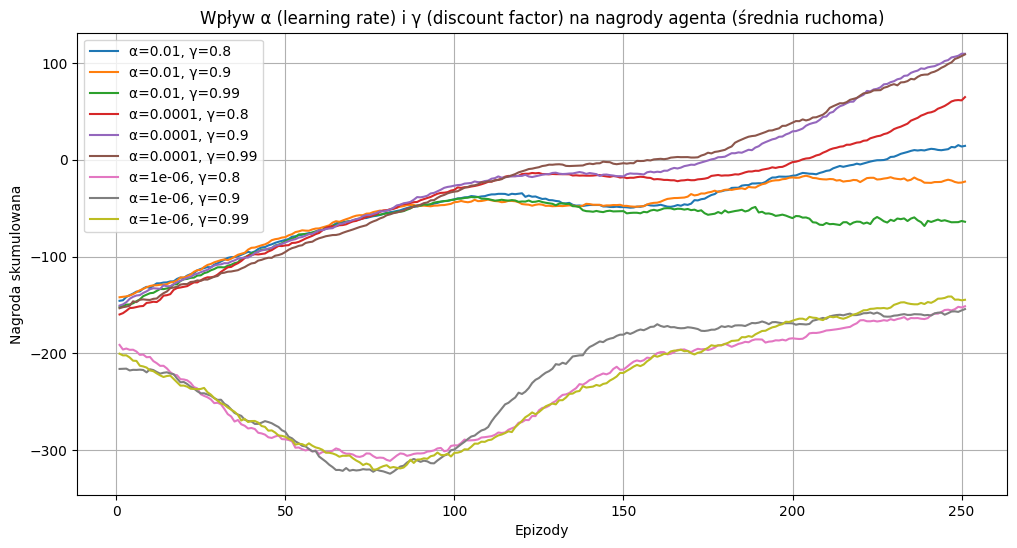

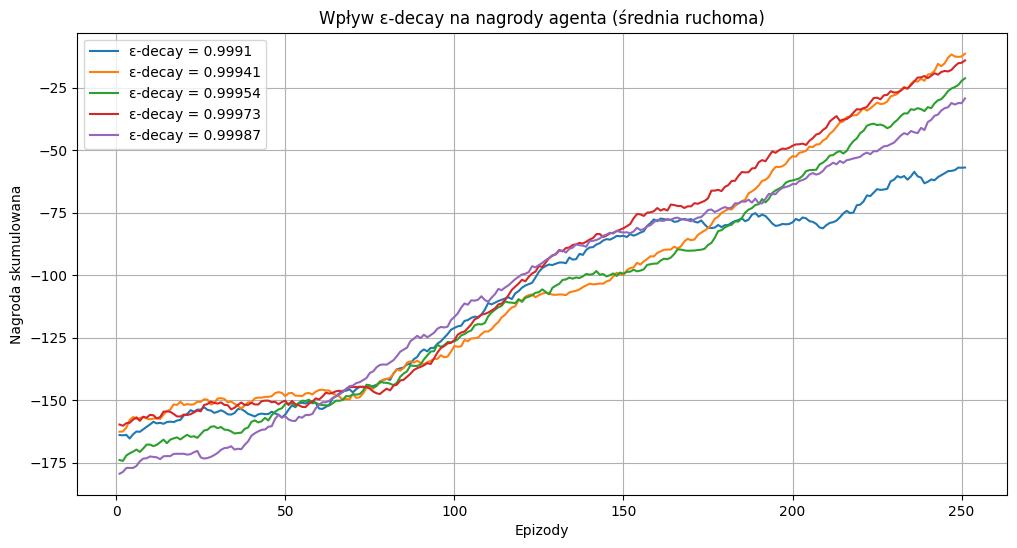

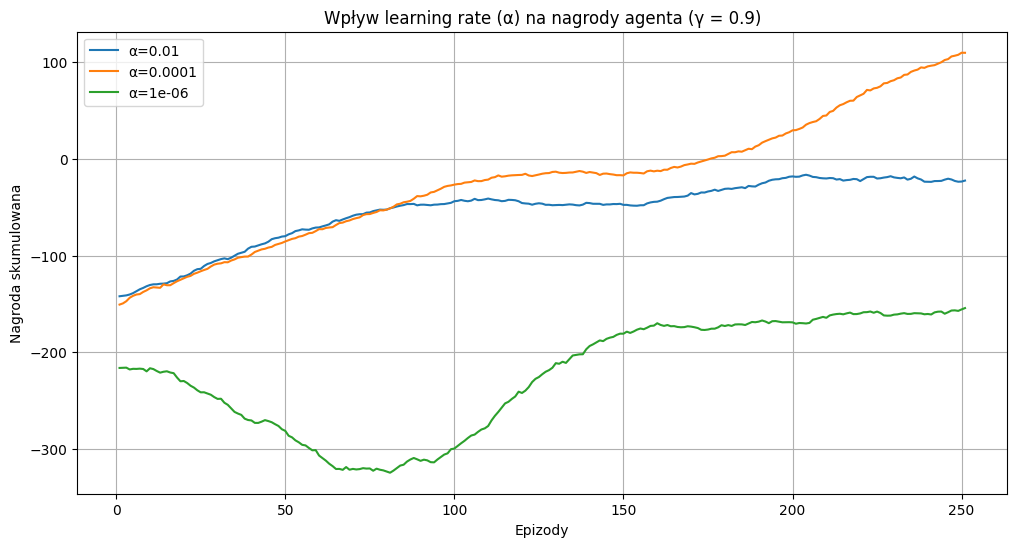

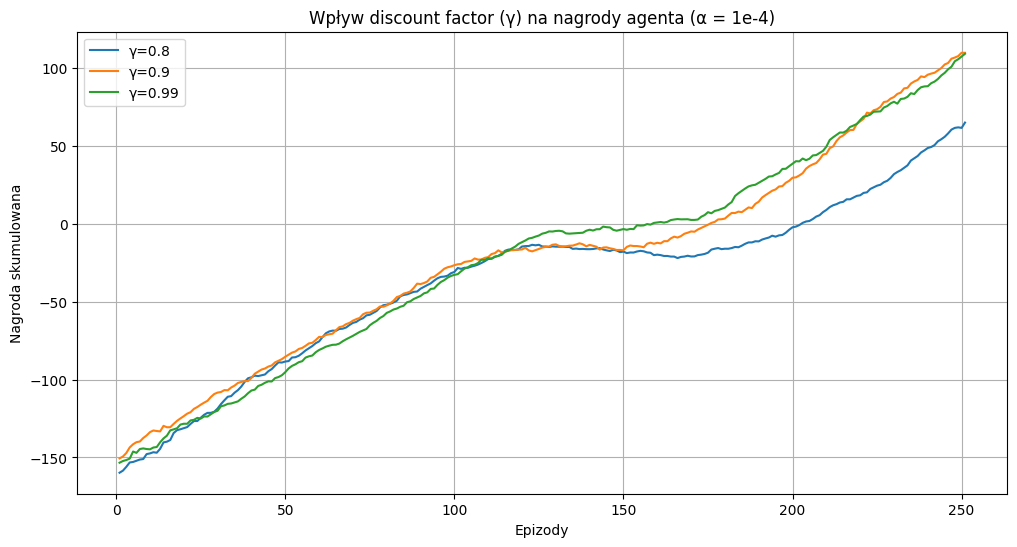

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Funkcja do obliczania średniej ruchomej
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Parametr okna średniej ruchomej
window_size = 50

# Wczytanie danych z pliku JSON
file_path = 'results1.json'  # Podaj ścieżkę do pliku JSON
with open(file_path, 'r') as file:
    data = json.load(file)

# Grupowanie danych według learning_rate i gamma
learning_rate_gamma_results = {}
e_decay_results = {}
for entry in data:
    alpha, gamma, e_decay = entry["alpha"], entry["gamma"], entry.get("epsilon_decay", None)

    # Grupowanie według alpha i gamma
    key = (alpha, gamma)
    if key not in learning_rate_gamma_results:
        learning_rate_gamma_results[key] = []
    learning_rate_gamma_results[key].append(entry["rewards"])

    # Grupowanie według epsilon_decay
    if e_decay is not None:
        if e_decay not in e_decay_results:
            e_decay_results[e_decay] = []
        e_decay_results[e_decay].append(entry["rewards"])

# Diagram 1: Wpływ learning rate (α) i gamma (γ) na nagrody agenta
plt.figure(figsize=(12, 6))
for (alpha, gamma), rewards_list in learning_rate_gamma_results.items():
    mean_rewards = np.mean(rewards_list, axis=0)
    smoothed_rewards = moving_average(mean_rewards, window_size)
    smoothed_episodes = range(1, len(smoothed_rewards) + 1)

    plt.plot(smoothed_episodes, smoothed_rewards, label=f'α={alpha}, γ={gamma}')

plt.title('Wpływ α (learning rate) i γ (discount factor) na nagrody agenta (średnia ruchoma)')
plt.xlabel('Epizody')
plt.ylabel('Nagroda skumulowana')
plt.legend()
plt.grid()
plt.show()

# Diagram 2: Wpływ epsilon-decay na nagrody agenta
plt.figure(figsize=(12, 6))
for e_decay, rewards_list in e_decay_results.items():
    mean_rewards = np.mean(rewards_list, axis=0)
    smoothed_rewards = moving_average(mean_rewards, window_size)
    smoothed_episodes = range(1, len(smoothed_rewards) + 1)

    plt.plot(smoothed_episodes, smoothed_rewards, label=f'ε-decay = {e_decay}')

plt.title('Wpływ ε-decay na nagrody agenta (średnia ruchoma)')
plt.xlabel('Epizody')
plt.ylabel('Nagroda skumulowana')
plt.legend()
plt.grid()
plt.show()

# Diagram 3: Wpływ learning rate (α) przy stałym gamma = 0.9
plt.figure(figsize=(12, 6))
for (alpha, gamma), rewards_list in learning_rate_gamma_results.items():
    if gamma == 0.9:  # Stały discount factor
        mean_rewards = np.mean(rewards_list, axis=0)
        smoothed_rewards = moving_average(mean_rewards, window_size)
        smoothed_episodes = range(1, len(smoothed_rewards) + 1)

        plt.plot(smoothed_episodes, smoothed_rewards, label=f'α={alpha}')

plt.title('Wpływ learning rate (α) na nagrody agenta (γ = 0.9)')
plt.xlabel('Epizody')
plt.ylabel('Nagroda skumulowana')
plt.legend()
plt.grid()
plt.show()

# Diagram 4: Wpływ discount factor (γ) przy stałym learning rate = 1e-4
plt.figure(figsize=(12, 6))
for (alpha, gamma), rewards_list in learning_rate_gamma_results.items():
    if alpha == 1e-4:  # Stały learning rate
        mean_rewards = np.mean(rewards_list, axis=0)
        smoothed_rewards = moving_average(mean_rewards, window_size)
        smoothed_episodes = range(1, len(smoothed_rewards) + 1)

        plt.plot(smoothed_episodes, smoothed_rewards, label=f'γ={gamma}')

plt.title('Wpływ discount factor (γ) na nagrody agenta (α = 1e-4)')
plt.xlabel('Epizody')
plt.ylabel('Nagroda skumulowana')
plt.legend()
plt.grid()
plt.show()
